# **Trabalho \#3**:  Aprendizado de Máquina e Reconhecimento de Padrões MC886/MO444
Instituto de Computação (IC/UNICAMP), 2ᵒ Semestre, 2024

Profa. Sandra Avila, 2024s2

Trabalho proposto por Caio Petrucci Rosa (PAD), Cesar Guedes Carneiro (PED) e Sandra Avila.



In [ ]:
# TODO: RA & Nome
print('291195: ' + 'Carlos Eduardo Tavares Norat')
print('216213: ' + 'Gabriel Dourado Seabra')

291195: Carlos Eduardo Tavares Norat
216213: Gabriel Dourado Seabra


## Objetivo

Explore **redes neurais** e desenvolva o melhor modelo possível para o problema, evitando *overfitting*. Em particular, construa um sistema de reconhecimento de objetos para classificar imagens usando a base de dados OrganCMNIST.

Nesta atividade, você não tem permissão para usar frameworks de redes neurais (por exemplo, Pytorch, Tensorflow, Keras), exceto funções básicas, como Dataloaders, que já estão especificadas nas células de código. Você deve implementar os métodos necessários usando NumPy. Além disso, você pode usar scikit-learn (ou bibliotecas similares) para calcular métricas de avaliação, e todas as bibliotecas de plotagem de gráficos também são permitidas.

Criamos uma verificação de integridade (*sanity check*, teste de sanidade) para todos os métodos que você precisa implementar, para que você possa verificar se o comportamento geral do seu algoritmo está correto. No entanto, isso não garante que sua implementação esteja correta, já que, infelizmente, depurar modelos de redes neurais não é uma tarefa simples.

---

## Prazo

**Prazo de entrega:** 06 de Novembro, quarta-feira, 23:59.

**Política de penalidades por envio atrasado:** Você não está sendo encorajada(o) a submeter o trabalho após a data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:
- 07 de Novembro, 23:59: nota * 0,75
- 08 de Novembro, 23:59: nota * 0,5
- 09 de Novembro, 23:59: nota * 0,25

## Envio

No Google Classroom, envie seu Jupyter Notebook, no formato `RA1_RA2_2024s2_mc886mo444_trabalho_03.ipynb`.

**Esta atividade NÃO é individual, deve ser realizada em dupla (grupo de duas pessoas).**

---

## 1. Base de Dados

O OrganCMNIST é um dos conjuntos de dados de imagem do [MedMNIST](https://medmnist.com/), derivado de imagens de tomografia computadorizada (CT) 3D do *Liver Tumor Segmentation Benchmark* (LiTS). O conjunto de dados contém fatias 2D recortadas das vistas coronais das imagens 3D originais, focando em 11 órgãos do corpo. As anotações de caixas delimitadoras (*bounding boxes*) de um estudo separado são usadas para obter os rótulos dos órgãos. As Unidades Hounsfield (HU) das tomografias são transformadas em tons de cinza utilizando uma janela abdominal, e cada imagem é redimensionada para 1x28x28 pixels para facilitar a classificação multi-classe.

O OrganCMNIST inclui um total de 23.583 imagens organizadas em 11 classes. O conjunto de dados é dividido em:
* 12.975 exemplos de treinamento,
* 2.392 exemplos de validação, e
* 8.216 exemplos de teste.

Cada exemplo é uma imagem em escala de cinza (1x28x28) associada a um rótulo de uma das 11 classes de órgãos.

Cada exemplo é atribuído a um dos seguintes rótulos:

| ID da Classe | Órgão | # Imagens | % |
|:---:|:---|---:|---:|
| 0 | bladder (bexiga) | 2167 | 9,19 |
| 1 | femur-left (fêmur-esquerdo) | 1152 | 4,88 |
| 2 | femur-right (fêmur-direito) | 1112 | 4,72 |
| 3 | heart (coração) | 1223 | 5,19 |
| 4 | kidney-left (rim-esquerdo) | 1947 | 8,26 |
| 5 | kidney-right (rim-direito) | 2062 | 8,74 |
| 6 | liver (fígado) | 5250 | 22,26 |
| 7 | lung-left (pulmão-esquerdo) | 1898 | 8,05 |
| 8 | lung-right (pulmão-direito) | 1931 | 8,19 |
| 9 | pancreas (pâncreas) | 2102 | 8,91 |
| 10 | spleen (baço) | 2739 | 11,61 |

Esta base de dados oferece uma representação simplificada dos órgãos abdominais, tornando-o adequado para tarefas de classificação multi-classe em pesquisas de imagens médicas.

#### **Informações sobre a base de dados**

- Os dados estão disponíveis no Google Sala de Aula (Classroom) junto a atividade.
- Você deve respeitar a divisão de treino/validação/teste disponibilizada no Google Sala de Aula (Classroom). Evite *overfitting*.
- Você deve avaliar os modelos usando **balanced accuracy** ou **AUC**. Utilizaremos a **balanced accuracy** na submissão do Kaggle.

In [ ]:
from typing import List
from abc import ABC,abstractmethod
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import balanced_accuracy_score
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
# prepara os dados usando o Dataloader do Pytorch

class OrganCMNIST(Dataset):
    def __init__(self, x, y=None, transform=None):
        self._x = x
        self._y = y.squeeze() if y is not None else None
        self._transform = transform
        self._num_classes = 11

    def __len__(self):
        return self._x.shape[0]

    def __getitem__(self, idx):
        image = self._x[idx]
        if self._transform is not None:
            image = self._transform(image)

        image = image.flatten()
        if self._y is None:
            return image

        # one hot encoding
        label = [0] * self._num_classes
        label[self._y[idx]] = 1
        return image, torch.Tensor(label)

In [ ]:
# um exemplo de uma função de normalização, você pode implementar outra caso ache necessário
def normalize(X):
    return (X - X.mean())/(X.std() + 1e-8)

#### **Carregando os dados**

In [ ]:
# defina o caminho para o dataset adequadamente
dataset_path = 'data.npz'
organcmnist = np.load(dataset_path)

x_train, y_train = organcmnist['train_images'], organcmnist['train_labels']
x_val, y_val = organcmnist['val_images'], organcmnist['val_labels']

# você não terá acesso à label do conjunto de teste
x_test = organcmnist['test_images']

In [ ]:
train_set = OrganCMNIST(x_train, y_train, transform=normalize)
val_set = OrganCMNIST(x_val, y_val, transform=normalize)
test_set = OrganCMNIST(x_test, transform=normalize)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

## 2. Implementação do *Framework*

#### **Funções de ativação e funções de perda**

As funções de ativação são componentes essenciais de uma rede neural. Portanto, explore diferentes funções de ativação em seus modelos e analise as diferenças nos resultados. Além disso, implemente a função de perda *cross-entropy* e use-a como sua função de perda, já que você está trabalhando em um problema de classificação multiclasse.

Implemente, no local indicado, as seguintes funções:

* Softmax (o gradiente já está implementado);
* Cross-Entropy (o gradiente já está implementado);
* Uma função de ativação de sua preferência, bem como seu gradiente. Ela deve ser uma subclasse de ``BaseFunction``. (Para referência, leia este [post no blog](https://dwaithe.github.io/blog_20170508.html).)

In [ ]:
class BaseFunction(ABC):
    @abstractmethod
    def __call__(self, X):
        pass

    @abstractmethod
    def grad(self, X):
        pass


class ReLU(BaseFunction):
    def __call__(self, X):
        return np.maximum(np.zeros_like(X), X)

    def grad(self, X):
        return np.where(X >= 0, 1, 0)

# TODO: implemente aqui uma outra função de ativação

class Sigmoid(BaseFunction):
    def __call__(self, X):
         return 1 / (1 + np.exp(-X))

    def grad(self, X):
        sigmoid_X = self.__call__(X)
        return sigmoid_X * (1 - sigmoid_X)


class Softmax(BaseFunction):
    def __call__(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Softmax output
        """
        # Subtrai o máximo para evitar valores muito grandes no expoente
        X_exp = np.exp(X - np.max(X, axis=-1, keepdims=True))
        return X_exp / np.sum(X_exp, axis=-1, keepdims=True)
    def grad(self, X):
        return 1 # descarte esse gradiente


class CrossEntropy(BaseFunction):
    def __call__(self, Y, Y_pred):
        """
        Arguments:
        Y: (np.array) ground-truth labels
        Y_pred: (np.array) predicted labels

        Return:
        Cross-Entropy output
        """
        const = 1e-16 # evita log(0)
        return -np.sum(Y * np.log(Y_pred + const)) / Y.shape[0]

    def grad(self, Y, Y_pred):
        return Y_pred - Y # gradiente em relação ao input do Softmax

**Verificação de integridade (*sanity check*)**

In [ ]:
######## checando o Softmax ########

s = Softmax()
x = np.array([[0,0],
              [1,2],
              [-3,2]])

expected_softmax = np.array([[0.5       , 0.5       ],
                             [0.26894142, 0.73105858],
                             [0.00669285, 0.99330715]])
result_softmax = s(x)
assert (abs(result_softmax - expected_softmax) < 1e-8).all(), f"Expected result for softmax is {expected_softmax}, but it returns {result_softmax}"

In [ ]:
######## checando a CrossEntropy ########
Y = np.array([[0, 1, 1],
              [1, 0, 0]])

Y_pred = np.array([[0, 1, 1],
                   [0.7, 0, 0.3],])


expected_ce = 0.1783374548265092
cross_entropy = CrossEntropy()
ce_result = cross_entropy(Y, Y_pred)
#assert abs(ce_result - expected_ce) < 1e-8, f"Expected result for cross entropy is {expected_ce}, but it returns {ce_result}"

expected_grad = np.array([[ 0. ,  0. ,  0. ],
                          [-0.3,  0. ,  0.3]])
grad = cross_entropy.grad(Y, Y_pred)
#assert (abs(grad - expected_grad) < 1e-8).all(), f"Expected result for cross entropy gradient is {expected_grad}, but it returns {grad}"

#### **Modelo de rede neural**

Em uma rede neural, as previsões são feitas usando um algoritmo chamado *feedforward*, também conhecido como a etapa de avanço. Portanto, você deve implementar este método para fazer previsões usando seus modelos.

Além disso, é fundamental inicializar os pesos da rede corretamente para garantir um modelo de melhor desempenho. Caso contrário, pode ocorrer o problema do gradiente que desaparece (*vanishing gradient*) ou explode (*exploding gradient*). Portanto, experimente diferentes técnicas de inicialização de pesos e veja o que acontece. Nós já implementamos a inicialização normal aleatória e a inicialização de [He et al.](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) para você :D

Implemente, no local indicado, os seguintes métodos:

* *Feedforward*, também conhecido como *forward pass*;
* Um método de inicialização de pesos de sua escolha. Para referência, leia este [post no blog](https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/).

**Observação:** Note que as matrizes de pesos $W$ na rede são construídas de modo que $w^{l}_{i,j}$ seja o peso que conecta o $i$-ésimo neurônio na camada $l$ à $j$-ésima neurônio na camada seguinte, como ilustrado abaixo.

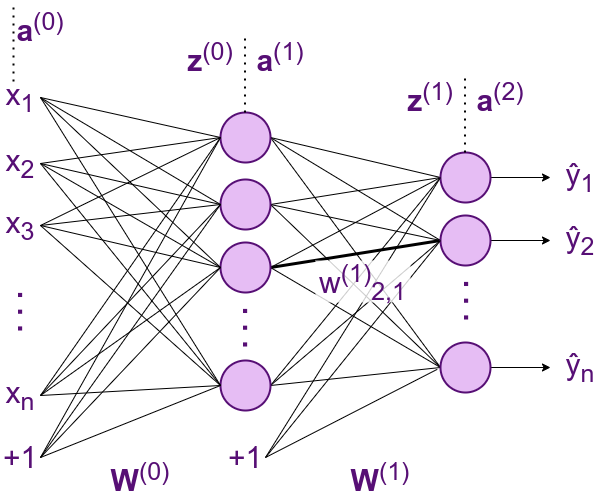

***Feedforward***:

Lembre-se que o cálculo do *forward pass* é calculado da seguinte forma:
> $a^{(L)} = f_{(L-1)}(z^{(L-1)})$

In [ ]:
class Model:
    def __init__(self, layers_dims: List[int],
                 activation_funcs: List[BaseFunction],
                 initialization_method: str = "random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        activation_funcs: (list) a list with the activation functions
        initialization_method: (str) indicates how to initialize the parameters

        Example:

        # a model architecture with layers 2 x 1 x 2 and 2 ReLU as activation functions
        >>> m = Model([2, 1, 2], [ReLU(), ReLU()])
        """

        assert all([isinstance(d, int) for d in layers_dims]), \
        "It is expected a list of int to the param ``layers_dims"

        assert all([isinstance(a, BaseFunction) for a in activation_funcs]), \
        "It is expected a list of BaseFunction to the param ``activation_funcs´´"

        self.layers_dims = layers_dims
        self.activation_funcs = activation_funcs
        self.weights, self.bias = self.initialize_model(initialization_method)


    def __len__(self):
        return len(self.weights)


    def initialize_model(self, method="random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        method: (str) indicates how to initialize the parameters

        Return: a list of matrices (np.array) of weights and a list of
        matrices (np.array) of biases.
        """

        weights = []
        bias = []
        n_layers = len(self.layers_dims)
        for l in range(0, n_layers-1):
            # os pesos w_i,j conectam o i-ésimo neurônio na camada atual ao
            # j-ésimo neuronio na próxima camada
            W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1])
            b = np.random.randn(1, self.layers_dims[l + 1])

            # He et al. Normal initialization
            if method.lower() == 'he':
                W = W * np.sqrt(2/self.layers_dims[l])
                b = b * np.sqrt(2/self.layers_dims[l])

            ###################################################
            # TODO: implemente outro método de inicialização
            ###################################################

          # Xavier Normalized initialization
            if method.lower() == 'xavier':
                std_dev = np.sqrt(2 / (self.layers_dims[l] + self.layers_dims[l + 1]))
                W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1]) * std_dev
                b = np.zeros((1, self.layers_dims[l + 1]))


            weights.append(W)
            bias.append(b)

        return weights, bias


    def forward(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Predictions for the input data (np.array)
        """
        activation = X
        self.activations = [X]
        self.Z_list = []
        #############################################################################
        # TODO: implemente aqui o forward step.
        #
        # Algumas instruções adicionais:
        # Note que os pesos, o bias e as funções de ativação são variáveis da classe,
        # então você pode acessá-los via ``self``.
        #
        # Você deve armazenar a entrada Z de cada função de ativação em ``Z_list``,
        # e a saída das funções de ativação em ``activations``. Essas
        # informações serão importantes quando você implementar a backward pass.
        #############################################################################
        for l in range(len(self.weights)):
            # Calculate Z(l)
            Z = (activation @ self.weights[l]) + self.bias[l]
            self.Z_list.append(Z)

            # Apply activation
            activation = self.activation_funcs[l](Z)
            self.activations.append(activation)
        return activation

**Verificação de integridade (*sanity check*)**

In [ ]:
######## checando o Forward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), ReLU()])

X = np.array([[0 ,1],
              [-1,0]])

W1 = np.array([[2],
               [1]])
b1 = np.array([[1]])
W2 = np.array([[2, 3]])
b2 = np.array([[1, -1]])

m.weights = [W1, W2]
m.bias = [b1, b2]

expected_prediction = np.array([[5,5],
                                [1,0]])

expected_Z_list = [np.array([[2],
                             [-1]]),
                   np.array([[5,5],
                             [1,-1]]),]

expected_activations = [X,
                        np.array([[2],
                                  [0]]),
                        expected_prediction]

#forward pass
prediction = m.forward(X)

for l, (expected_z, z) in enumerate(zip(expected_Z_list, m.Z_list)):
    assert ((z - expected_z) < 1e-8).all(), \
    f"Forward pass {l}: expected Z list is {expected_z}, but it returns {z}"

for l, (expected_a, a) in enumerate(zip(expected_activations, m.activations)):
    assert (abs(a-expected_a) < 1e-8).all(), \
    f"Forward pass {l}: expected activations are {expected_a}, but it returns {a}"

assert (abs(prediction - expected_prediction) < 1e-8).all(), \
f"Forward: expected result is {expected_prediction}, but it returns {prediction}"

#### **Otimizadores**

Depois de definir a topologia/arquitetura da sua rede neural, é hora de treiná-la. Para isso, você precisa selecionar um otimizador (por exemplo, SGD, Momentum, Adagrad, Adam, RMSProp) que irá atualizar os pesos da rede.

Implemente no local indicado:

* *Stochastic Gradient Descent* (SGD);
* Outro otimizador de sua preferência. Ele deve ser uma subclasse de ``BaseOptimizer``. Para referência, leia https://www.ruder.io/optimizing-gradient-descent/.

In [ ]:
class BaseOptimizer(ABC):
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def step(self, grads):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.

        Return:
        """
        pass

class SGDOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3):
        self.model = model
        self.lr = lr

    def step(self, grads: List):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.

        Return:
        """
        ###############################################################
        # TODO: implemente o algoritmo de Stochastic Gradient Descent (SGD)
        ###############################################################

        self.model.weights = [w.astype(np.float64) for w in self.model.weights]
        self.model.bias = [b.astype(np.float64) for b in self.model.bias]

        for l in range(len(self.model.weights)):
            dW, db = grads[l]
            # Update weights and biases

            self.model.weights[l] -= float(self.lr) * dW
            self.model.bias[l] -= float(self.lr) * db


####################################
# TODO: implemente outro optimizador
####################################

class AdamOptimizer(BaseOptimizer):
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(model)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon # avoid zero division
        self.m = [np.zeros_like(w) for w in model.weights] # store tye mobile media of the gradients (first moment).
        self.v = [np.zeros_like(w) for w in model.weights] # store the mobile media of the gradients  squares (second moment).
        self.t = 0 # step

    def step(self, grads_list: List):
        """
        Arguments:
        grads_list: (list)  a list of tuples with matrices: [(gradients of weights, gradients of biases)].
        """
        self.t += 1
        for l in range(len(self.model.weights)):
            dW, db = grads_list[l]

            # Update biased first moment estimate
            self.m[l] = self.beta1 * self.m[l] + (1 - self.beta1) * dW
            # Update biased second raw moment estimate
            self.v[l] = self.beta2 * self.v[l] + (1 - self.beta2) * (dW ** 2)

            # Remove bias first momemnt
            m_corrected = self.m[l] / (1 - self.beta1 ** self.t)
            # Remove bias second moment
            v_corrected = self.v[l] / (1 - self.beta2 ** self.t)

            # Update weights and biases
            self.model.weights[l] = self.model.weights[l].astype(np.float64) - self.lr * m_corrected / (np.sqrt(v_corrected) + self.epsilon)
            # bias without momentum
            self.model.bias[l] = self.model.bias[l].astype(np.float64) - self.lr * db

**Verificação de integridade (*sanity check*)**

A verificação de integridade do SGD é colocada após o `Trainer` porque ela utiliza o algoritmo de retropropagação (*backpropagation*) para calcular os gradientes.

#### **Treinador (Classe `Trainer`)**

Um peso $w_{i,j}$ de uma rede neural é atualizado com base no gradiente da função de perda em relação a $w_{i,j}$. Portanto, precisamos calcular o gradiente da função de perda em relação a todos os pesos e vieses em cada camada da rede. Esse processo é chamado de retropropagação (*backpropagation*), também conhecido como etapa de retrocesso.

Implemente:
* Algoritmo de retropropagação (*backpropagation*).

> **Dica:**
>
> *Use as seguintes equações recursivas para calcular a retropropagação:*
>
> - $\frac{\partial C}{\partial z^{(L-1)}} = \frac{\partial C}{\partial a^{(L)}} \cdot \frac{\partial a^{(L)}}{\partial z^{(L-1)}}$
>
> - $\frac{\partial C}{\partial z^{(L)}} = [\frac{\partial C}{\partial z^{(L+1)}} \cdot W_{(L+1)}^T] \odot \frac{\partial f_{(L)}}{\partial z^{(L)}}$
>
> - $\frac{\partial C}{\partial W^{(L)}} = a^{(L)^T} \cdot \frac{\partial C}{\partial z^{(L)}}$
>
> - $\frac{\partial C}{\partial b^{(L)}} = \frac{\partial C}{\partial z^{(L)}}$
>
>onde $C$ é sua função de custo/perda, $a^{(L)}$ é a saída da última função de ativação, $z_i^{(L)}$ é a i-ésima linha da matriz $z^{(L)}$, e $\odot$ é o [produto de Hadamard](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) / produto elemento a elemento.

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, loss_func):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.batch_size = 0
        self.gradients = {}

    def backward(self, Y):
        """
        Arguments:
        Y: (np.array) ground truth/label vector.

        Return:
        A list of tuples of matrices (weights' gradient, biases' gradient) both in np.array format.
        The order of this list should be the same as the model's weights.
        For example: [(dW0, db0), (dW1, db1), ... ].
        """
        ############################################################
        # TODO: implemente aqui o backward step.
        ############################################################

        dA = self.loss_func.grad(Y, self.model.activations[-1])

        grads = []

        for l in reversed(range(len(self.model.weights))):
            dZ = dA * self.model.activation_funcs[l].grad(self.model.Z_list[l])
            dW = (self.model.activations[l].T @ dZ) / self.batch_size
            db = np.sum(dZ, axis=0, keepdims=True) / self.batch_size
            dA = dZ @ self.model.weights[l].T

            grads.insert(0, (dW, db))

        return grads


    def train(self, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader):
        """
        Arguments:
        n_epochs: (int) number of epochs
        train_loader: (DataLoader) train DataLoader
        val_loader: (DataLoader) validation DataLoader

        Return:
        A dictionary with the log of train and validation loss along the epochs
        """
        log_dict = {'epoch': [],
                   'train_loss': [],
                   'val_loss': []}

        self.batch_size = train_loader.batch_size
        for epoch in tqdm.tqdm_notebook(range(n_epochs)):
            train_loss_history = []

            for i, batch in enumerate(train_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)
                train_loss = self.loss_func(Y, Y_pred)
                train_loss_history.append(train_loss)

                grads = self.backward(Y)
                self.optimizer.step(grads)

            val_loss_history = []
            for i, batch in enumerate(val_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)
                val_loss = self.loss_func(Y, Y_pred)
                val_loss_history.append(val_loss)

            # anexando a perda ao historico
            train_loss = np.array(train_loss_history).mean()
            val_loss = np.array(val_loss_history).mean()

            log_dict['epoch'].append(epoch)
            log_dict['train_loss'].append(train_loss)
            log_dict['val_loss'].append(val_loss)

        return log_dict

**Verificação de integridade (*sanity check*)**

In [ ]:
######## checando o Backward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)

# Deixamos esse valor caso você precise checar seus resultados
#
# expected_dZ1 = np.array([[ 0.5       , -0.5       ],
#                         [-0.11920292,  0.11920292]])
#
# expected_dZ0 = np.array([[-0.5],
#                          [ 0. ]])
#
# y_pred = np.array([[0.5       , 0.5       ],
#                    [0.88079708, 0.11920292]])


expected_dW1 = np.array([[ 0.5, -0.5]])

expected_db1 = np.array([[ 0.19039854, -0.19039854]])

expected_dW0 = np.array([[ 0.  ],
                         [-0.25]])

expected_db0 = np.array([[-0.25]])

dW1, db1 = grads[1]
assert (abs(expected_dW1 - dW1) < 1e-8).all(), f"Expected result for dW1 is {expected_dW1}, but it returns {dW1}"
assert (abs(expected_db1 - db1) < 1e-8).all(), f"Expected result for db1 is {expected_db1}, but it returns {db1}"

dW0, db0 = grads[0]
assert (abs(expected_dW0 - dW0) < 1e-8).all(), f"Expected result for dW0 is {expected_dW0}, but it returns {dW0}"
assert (abs(expected_db0 - db0) < 1e-8).all(), f"Expected result for db0 is {expected_db0}, but it returns {db0}"

In [ ]:
######## checando o SGD Optimizer ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)
opt = SGDOptimizer(m, lr=1)
opt.step(grads)

expected_W0 = np.array([[2.  ],
                        [1.25]])
expected_b0 = np.array([[1.25]])

expected_W1 = np.array([[1.5, 3.5]])
expected_b1 = np.array([[ 0.80960146, -0.80960146]])

W0, b0 = m.weights[0], m.bias[0]
assert (abs(expected_W0 - W0) < 1e-8).all(), f"Expected result for W0 after SGD update step is {expected_W0}, but it returns {W0}"
assert (abs(expected_b0 - b0) < 1e-8).all(), f"Expected result for b0 after SGD update step is {expected_b0}, but it returns {b0}"

W1, b1 = m.weights[1], m.bias[1]
assert (abs(expected_W1 - W1) < 1e-8).all(), f"Expected result for W1 after SGD update step is {expected_W1}, but it returns {W1}"
assert (abs(expected_b1 - b1) < 1e-8).all(), f"Expected result for b1 after SGD update step is {expected_b1}, but it returns {b1}"

#### **Exemplo de uso**

Exemplo de uso do *framework* que acabamos de criar.

In [ ]:
# Função para auxiliar no plot da perda ao longo das épocas
def plot_history(history):
    """
    Plot loss history
    """
    fig, ax = plt.subplots()
    ax.plot(history['train_loss'], color='#407cdb', label='Train')
    ax.plot(history['val_loss'],color='#db5740', label='Validation')

    ax.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss along the training')
    plt.show()

<ipython-input-18-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/15 [00:00<?, ?it/s]

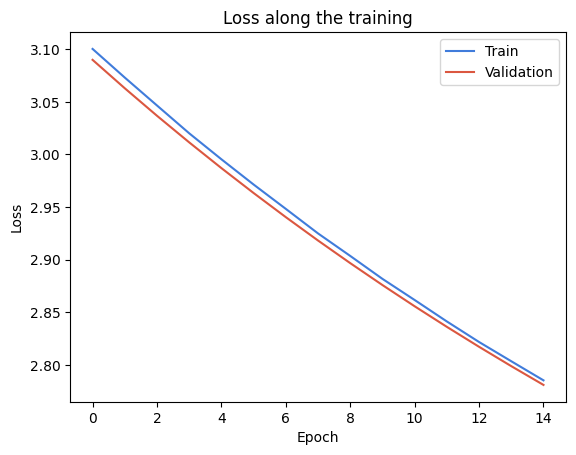

In [ ]:
model = Model([784, 392, 100, 11], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)

## 3. Atividades Exploratórias

Para todos os exercícios, plote a perda ao longo das épocas e reporte o desempenho do seu modelo no conjunto de validação. Cuidado com *underfitting* e *overfitting*.

1. (1 ponto) Projete uma Rede Neural, usando uma ou duas camadas ocultas, ReLU e softmax como funções de ativação, inicialização de pesos aleatória e SGD para treiná-la. Você deve escolher uma taxa de aprendizado apropriada e um número de épocas.

<ipython-input-18-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

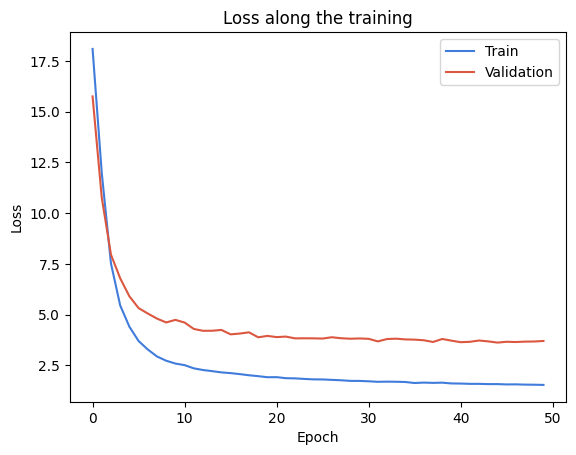

Balanced Accuracy: 0.23374699744784674


In [ ]:
model = Model([784, 256, 128, 11], [ReLU(), ReLU(), Softmax()], initialization_method="random")
opt = SGDOptimizer(model, lr=1e-2)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(50, train_loader, val_loader)
plot_history(history)

y_pred = [int(np.argmax(model.forward(x_val[i].flatten()), axis=1)[0]) for i in range(x_val.shape[0])]
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)

print("Balanced Accuracy:", balanced_accuracy)

> **Quais foram suas conclusões? (1-2 parágrafos)**
>
> Com a inicialização aleatória, percebe-se que as curvas de loss de validação e verificação estabilizam em um mínimo local ainda alto. Isso resulta em uma baixa acurácia verificada do modelo resultante no conjunto de validação -- em torno de 0.23.

Usando o Adam

2. (2 pontos) Experimente outras duas técnicas de inicialização de pesos e *bias* (normalização de He et al. e a outra que você implementou).

Inicialização Normal de He et al.

<ipython-input-18-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

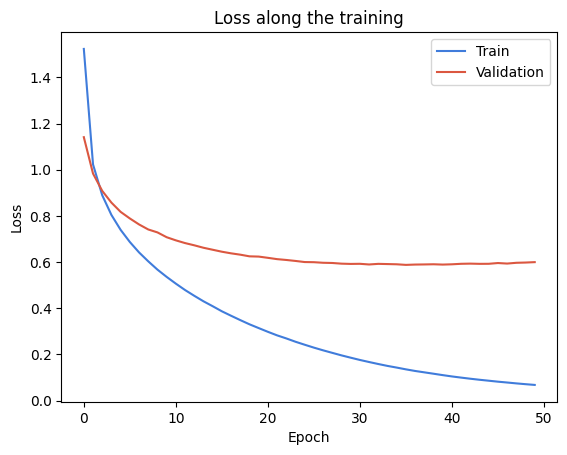

Balanced Accuracy: 0.2877123760885394


In [ ]:
model = Model([784, 256, 128, 11], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-2)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(50, train_loader, val_loader)
plot_history(history)
y_pred = [int(np.argmax(model.forward(x_val[i].flatten()), axis=1)[0]) for i in range(x_val.shape[0])]
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)

print("Balanced Accuracy:", balanced_accuracy)

Inicialização Normalizada de Xavier et al.

<ipython-input-18-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

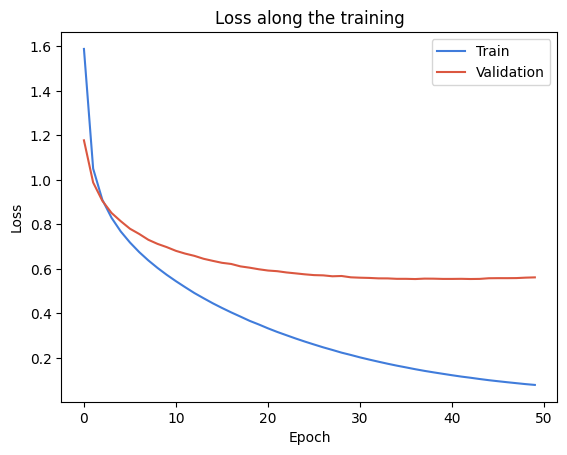

Balanced Accuracy: 0.3994923807349718


In [ ]:
model = Model([784, 256, 128, 11], [ReLU(), ReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-2)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(50, train_loader, val_loader)
plot_history(history)
y_pred = [int(np.argmax(model.forward(x_val[i].flatten()), axis=1)[0]) for i in range(x_val.shape[0])]
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)

print("Balanced Accuracy:", balanced_accuracy)

> **Quais são as conclusões? Como as técnicas influenciam o desempenho dos modelos? (1-2 parágrafos)**
>
> Percebe-se que a inicialização por Xavier apresentou uma melhor acurácia no conjunto de validação, embora ambos apresentaram curvas de aprendizado semelhantes. Os melhores resultados com Xavier indicam que o modelo pode ter se beneficiado de uma inicialização com menor variância.

3. (1 ponto) Escolha a técnica de inicialização de pesos e *bias* que resultou no melhor desempenho e experimente a outra função de ativação que você implementou.

<ipython-input-18-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/50 [00:00<?, ?it/s]

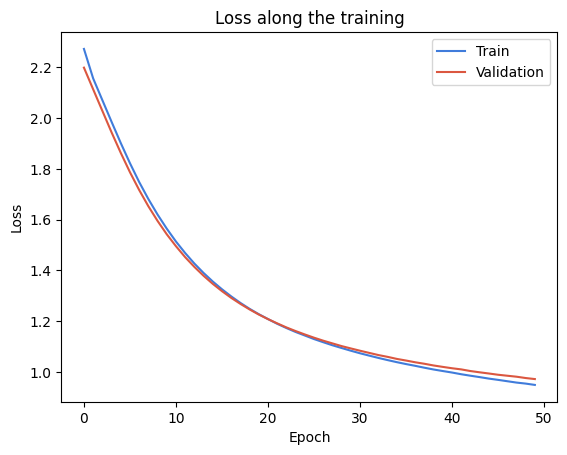

<ipython-input-12-84425bf35448>:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Balanced Accuracy: 0.5895524656051792


In [ ]:
model = Model([784, 256, 128, 11], [Sigmoid(), Sigmoid(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-2)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(50, train_loader, val_loader)
plot_history(history)

y_pred = [int(np.argmax(model.forward(x_val[i].flatten()), axis=1)[0]) for i in range(x_val.shape[0])]
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)

print("Balanced Accuracy:", balanced_accuracy)

> **Quais são as conclusões? Isso faz alguma diferença nos resultados? (1-2 parágrafos)**
>
> Percebe-se que, ao substituir as ativações das camadas escondidas, de ReLU para Sigmoide, obtivemos um aumento significativo na acurácia -- que foi de 0.40 para 0.59. Isso pode ser explicado pela estabilização que a sigmoide traz para redes rasas e pela natureza mais suave de suas ativações, enquanto a ReLU pode ter sofrido de instabilidade ou oscilações nos gradientes que prejudicaram a acurácia final.

4. (3 pontos) Explore diferentes arquiteturas de rede, variando o número de camadas e o número de neurônios em cada camada. É um experimento empírico.

Current architecture training: [784, 128, 11]


<ipython-input-18-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/75 [00:00<?, ?it/s]

Architecture: [784, 128, 11]


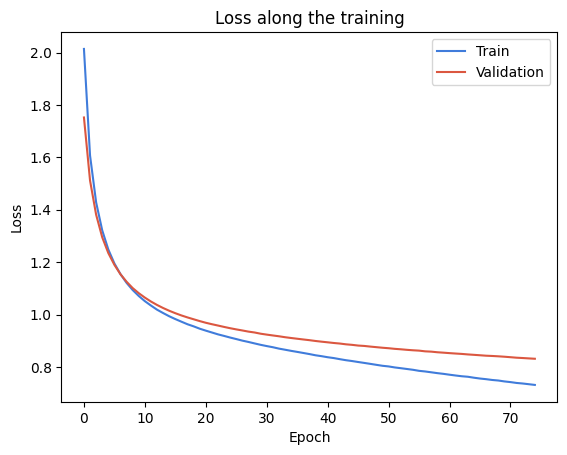

<ipython-input-12-84425bf35448>:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Balanced Accuracy: 0.5686111202202043
Current architecture training: [784, 256, 11]


<ipython-input-18-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/75 [00:00<?, ?it/s]

Architecture: [784, 256, 11]


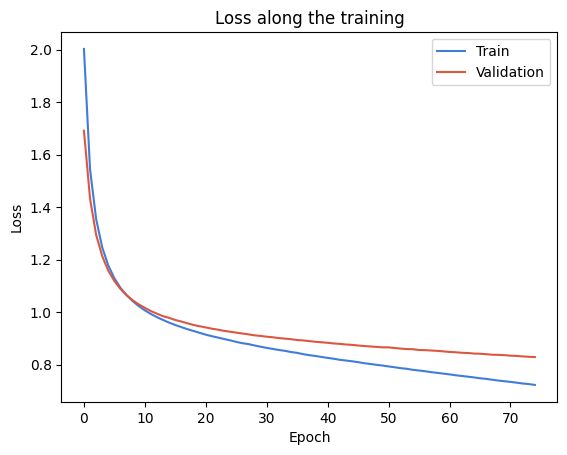

<ipython-input-12-84425bf35448>:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Balanced Accuracy: 0.616199695717293
Current architecture training: [784, 128, 64, 11]


<ipython-input-18-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/75 [00:00<?, ?it/s]

Architecture: [784, 128, 64, 11]


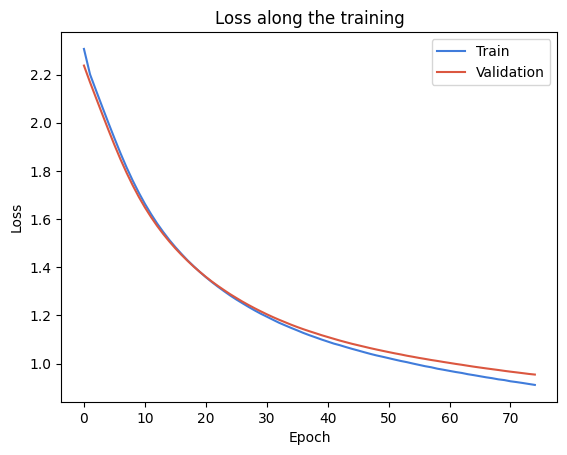

<ipython-input-12-84425bf35448>:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Balanced Accuracy: 0.5560350370579307


In [ ]:
# Arquiteturas:
architectures = [
    [784, 128, 11],
    [784, 256, 11],
    [784, 128, 64, 11]
]
all_histories = []

for arch in architectures:
    print(f"Current architecture training: {arch}")
    model = Model(arch, [Sigmoid() for _ in range(len(arch) - 2)] + [Softmax()], initialization_method="xavier")
    opt = SGDOptimizer(model, lr=1e-2)
    trainer = Trainer(model, opt, CrossEntropy())

    history = trainer.train(75, train_loader, val_loader)
    all_histories.append((arch, history))
    print(f"Architecture: {arch}")
    plot_history(history)

    y_pred = [int(np.argmax(model.forward(x_val[i].flatten()), axis=1)[0]) for i in range(x_val.shape[0])]
    balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    print(f"Balanced Accuracy:", balanced_accuracy)

> **Quais são as conclusões? Como o número de camadas impacta o desempenho dos modelos? (2-4 parágrafos)**
>
Testamos três arquiteturas diferentes: duas com apenas uma camada escondida e uma com duas camadas escondidas. A primeira com metade dos neurônios na camada escondida que a segunda. A que apresentou o melhor resultado foi com apenas uma camada escondida, porém com mais neurônios na camada escondida [784, 256, 11].

Percebemos que aumentar o número de parâmteros e o número de camadas piorou o nosso modelo, porém usar mais neurônios na camada escondida o beneficiou. O melhor desempenho com uma camada única e mais neurônios indica que essa configuração oferece uma capacidade de representação suficiente, com menor risco de overfitting e maior eficiência no aprendizado dos pesos.

5. (2 pontos) Escolha a melhor arquitetura de rede e treine seu modelo usando o otimizador que você escolheu implementar.

<ipython-input-12-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/75 [00:00<?, ?it/s]

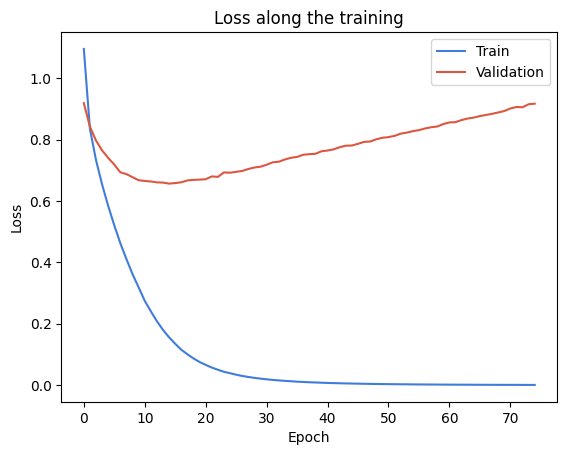

<ipython-input-6-84425bf35448>:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Balanced Accuracy: 0.544640880088763


In [ ]:
model = Model([784, 256, 11], [Sigmoid(), Softmax()], initialization_method="xavier")
opt = AdamOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(75, train_loader, val_loader)
plot_history(history)

y_pred = [int(np.argmax(model.forward(x_val[i].flatten()), axis=1)[0]) for i in range(x_val.shape[0])]
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
print(f"Balanced Accuracy:", balanced_accuracy)

> **Quais são as conclusões? A mudança de otimizador impacta de alguma forma a curva de perda ao longo das épocas? (1-2 parágrafos)**
>
> Apesar da utilização do otimizador Adam, que combina uma adaptação da taxa de aprendizado com um acúmulo de "momentum" para melhorar a convergência e eficiência, o gráfico mostra claramente um comportamento típico de overfitting. Podemos ver que a perda no conjunto de treinamento (Train) está diminuindo continuamente e atingindo praticamente zero, enquanto a perda no conjunto de validação (Validation) começa a aumentar após cerca de 35 épocas.

6. (1 ponto) Escolha seu melhor modelo, faça previsões para o conjunto de teste e envie-as para a competição [Redes Neurais – Tarefa #3 de MC886/MO444 2024S2](https://www.kaggle.com/t/f3a05870932d4bb49d59d18cc4a44a2d) no Kaggle. Reporte sua pontuação considerando a tabela de classificação pública. A plataforma calculará automaticamente a métrica de avaliação, a **acurácia balanceada**.

> **Observação:** Não se preocupe apenas com o resultado do seu modelo. O seu resultado no placar não irá influenciar a sua nota nesta atividade :).

Training best model

<ipython-input-12-c762ca9d46f6>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epochs)):


  0%|          | 0/75 [00:00<?, ?it/s]

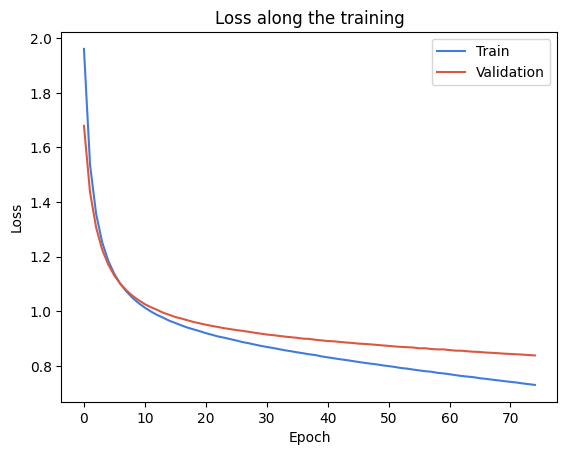

<ipython-input-6-84425bf35448>:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Balanced Accuracy: 0.5758163958333251


In [ ]:
best_model = Model([784, 256, 11], [Sigmoid(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(best_model, lr=1e-2)
trainer = Trainer(best_model, opt, CrossEntropy())
history = trainer.train(75, train_loader, val_loader)
plot_history(history)

y_pred = [int(np.argmax(best_model.forward(x_val[i].flatten()), axis=1)[0]) for i in range(x_val.shape[0])]
balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
print(f"Balanced Accuracy:", balanced_accuracy)

Getting results in the test data

In [ ]:
test_predictions = []
for i, x in enumerate(test_loader):
    x_np = x.numpy()
    preds = best_model.forward(x_np)
    predicted_labels = np.argmax(preds, axis=1)
    for id_x, label in enumerate(predicted_labels):
        # Concatenate the batches
        test_predictions.append((i * x.shape[0] + id_x + 1, label)) # This sum gives the index of the image in the entire test set

In [ ]:
ids = range(1, len(test_predictions) + 1)
predicted_classes = [pred_tuple[1] for pred_tuple in test_predictions]
submission_df = pd.DataFrame({'Label': predicted_classes}, index=ids)
submission_df.index.name = 'id'
submission_df.to_csv('submission-1.csv', header=True)

In [ ]:
submission_df.head()

,Label
id,
1,10
2,3
3,9
4,9
5,7


> **Quais foram suas conclusões? (1-2 parágrafos)**
>
> O modelo obteve uma performance maior do que o esperado no conjunto de teste (70% de acurácia balanceada), visto que a performance obtida na validação era próxima de 60%. Esse resultado indica que o modelo conseguiu generalizar melhor do que o previsto, possivelmente devido a uma distribuição similar entre os dados de validação e teste, o que contribuiu para um ajuste mais adequado dos parâmetros.


---

## Prazo

**Prazo de entrega:** 06 de Novembro, quarta-feira, 23:59.

**Política de penalidades por envio atrasado:** Você não está sendo encorajada(o) a submeter o trabalho após a data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:
- 07 de Novembro, 23:59: nota * 0,75
- 08 de Novembro, 23:59: nota * 0,5
- 09 de Novembro, 23:59: nota * 0,25

## Envio

No Google Classroom, envie seu Jupyter Notebook, no formato `RA1_RA2_2024s2_mc886mo444_trabalho_03.ipynb`.

**Esta atividade NÃO é individual, deve ser realizada em dupla (grupo de duas pessoas).**